In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

root_dir = Path().absolute()
# Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
if root_dir.parts[-1:] == ('notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
    sys.path.append(str(root_dir))
if root_dir.parts[-1:] == ('ccfraud',):
    root_dir = Path(*root_dir.parts[:-1])
    sys.path.append(str(root_dir))
root_dir = str(root_dir) 

print(f"Root dir: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Root dir: /home/jdowling/Projects/mlfs-book
HopsworksSettings initialized!


In [2]:
import hopsworks
import pandas as pd
import shutil

proj = hopsworks.login()
fs = proj.get_feature_store()
mr = proj.get_model_registry()

2026-01-21 11:33:37,517 INFO: Initializing external client


2026-01-21 11:33:37,518 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443


2026-01-21 11:33:38,765 INFO: Python Engine initialized.



Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/120


In [3]:
merchant_fg = fs.get_feature_group("merchant_details", version=1)
account_fg = fs.get_feature_group("account_details", version=1)
bank_fg = fs.get_feature_group("bank_details", version=1)
card_fg = fs.get_feature_group("card_details", version=1)
cc_trans_aggs_fg = fs.get_feature_group("cc_trans_aggs_fg", version=1)
cc_trans_fg = fs.get_feature_group("cc_trans_fg", version=1)

In [4]:
subtree1 = cc_trans_aggs_fg.select_except(['t_id','cc_num','account_id','bank_id','event_time'])\
    .join(account_fg.select(['debt_end_prev_month']), on="account_id", join_type="inner")\
    .join(bank_fg.select(['credit_rating', 'days_since_bank_cr_changed', 'country']), prefix="bank_", on="bank_id", join_type="inner")

In [5]:
# df = subtree1.read()
# df.isna().sum().sort_values(ascending=False)
# df

In [6]:
selection = cc_trans_fg.select_except(['t_id', 'cc_num', 'merchant_id', 'account_id', 'ip_address', 'ts'])\
    .join(merchant_fg.select_features(), on="merchant_id", join_type="inner")\
    .join(subtree1, on="cc_num")
# , prefix="aggs_"
# , prefix="merchant_"

2026-01-21 11:33:45,158 INFO: Using ['category', 'country', 'cnt_chrgeback_prev_day', 'cnt_chrgeback_prev_week', 'cnt_chrgeback_prev_month'] from feature group `merchant_details` as features for the query. To include primary key and event time use `select_all`.


In [7]:
df = selection.read()
df.isna().sum().sort_values(ascending=False)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (13.97s) 


prev_ip_address                    2634
prev_card_present                  2623
prev_ts                            2376
amount                                0
sum_trans_last_hour                   0
bank_days_since_bank_cr_changed       0
bank_credit_rating                    0
debt_end_prev_month                   0
sum_trans_last_week                   0
num_trans_last_week                   0
sum_trans_last_day                    0
num_trans_last_day                    0
num_trans_last_hour                   0
time_since_last_trans                 0
sum_trans_last_10_mins                0
num_trans_last_10_mins                0
cnt_chrgeback_prev_month              0
cnt_chrgeback_prev_week               0
cnt_chrgeback_prev_day                0
country                               0
category                              0
haversine_distance                    0
is_fraud                              0
days_to_card_expiry                   0
bank_country                          0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436968 entries, 0 to 436967
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   amount                           436968 non-null  float64       
 1   time_since_last_trans            436968 non-null  int64         
 2   days_to_card_expiry              436968 non-null  int64         
 3   is_fraud                         436968 non-null  bool          
 4   haversine_distance               436968 non-null  bool          
 5   category                         436968 non-null  object        
 6   country                          436968 non-null  object        
 7   cnt_chrgeback_prev_day           436968 non-null  float64       
 8   cnt_chrgeback_prev_week          436968 non-null  float64       
 9   cnt_chrgeback_prev_month         436968 non-null  float64       
 10  num_trans_last_10_mins           436968 non-

In [9]:
fv = fs.get_or_create_feature_view(name="cc_fraud_fv", 
                                   version=1, 
                                   description="features for a credit card fraud prediction model",
                                   query=selection,
                                   labels=['is_fraud'],
                                   inference_helper_columns=['prev_card_present','prev_ip_address','prev_ts'],
                                   logging_enabled=True
                                  )

In [10]:
fv.serving_keys

[{"feature_name": "merchant_id", "join_index": 1, "feature_group_id": 2467, "feature_group_name": "merchant_details", "feature_group_version": 1, "required": true, "prefix": "", "join_on": "merchant_id"},
 {"feature_name": "cc_num", "join_index": 0, "feature_group_id": 2474, "feature_group_name": "cc_trans_fg", "feature_group_version": 1, "required": true, "prefix": "", "join_on": null},
 {"feature_name": "cc_num", "join_index": 2, "feature_group_id": 2473, "feature_group_name": "cc_trans_aggs_fg", "feature_group_version": 1, "required": false, "prefix": "", "join_on": "cc_num"}]

In [11]:
# dict = fv.get_feature_vector(
#     entry={"cc_num": 1852-3633-7375-1086, "merchant_id": "MERCH_00000037"}, 
#     passed_features={
#         "t_id": 999767,
#         "amount": 333.00,
#         "ip_address": "84.0.241.63",
#         "card_present": True
#     },
#     request_parameters={"prev_ip_address": "84.0.241.63", 'prev_card_present': True, 'time_since_last_trans': 10},
#     allow_missing = True,
#     transform=False
# )

In [12]:
# Parameters (injected by papermill)
test_start = "2026-01-09 00:00"

In [13]:
# Parameters
test_start = "2026-01-14 00:00"


In [14]:
X_train, X_test, y_train, y_test = fv.train_test_split(test_start=test_start)
X_train

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (23.59s) 


2026-01-21 11:34:48,108 INFO: Computing insert statistics


2026-01-21 11:34:48,295 INFO: Computing insert statistics


,amount,time_since_last_trans,days_to_card_expiry,haversine_distance,category,country,cnt_chrgeback_prev_day,cnt_chrgeback_prev_week,cnt_chrgeback_prev_month,num_trans_last_10_mins,...,num_trans_last_hour,sum_trans_last_hour,num_trans_last_day,sum_trans_last_day,num_trans_last_week,sum_trans_last_week,debt_end_prev_month,bank_credit_rating,bank_days_since_bank_cr_changed,bank_country
0,13.98,-2588489,0,True,Department Stores,Argentina,0.75,5.82,20.56,1,...,1,13.98,1,13.98,1,13.98,1484.26,9,61,Indonesia
1,47.46,-2577288,0,True,Jewelry,Canada,0.91,5.46,30.62,1,...,1,47.46,1,47.46,1,47.46,683.48,9,61,Indonesia
2,66.46,-2584271,0,True,Gas Stations,Belgium,4.13,26.89,115.14,1,...,1,66.46,1,66.46,1,66.46,543.30,9,61,Indonesia
3,13.71,-2588248,0,True,Insurance,Japan,0.93,6.57,29.12,1,...,1,13.71,1,13.71,1,13.71,4476.09,9,61,Indonesia
4,35.36,-2584019,0,True,Beauty,Mexico,8.43,54.55,297.70,1,...,1,35.36,1,35.36,1,35.36,-53.88,9,61,Indonesia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435532,217.96,5789,0,False,Books,South Korea,2.88,23.28,81.69,1,...,1,217.96,6,463.81,34,3727.52,3185.13,10,262,Mexico
435533,16.32,2842,0,False,Department Stores,Argentina,0.75,5.82,20.56,1,...,2,45.20,6,224.82,54,5671.51,4570.14,10,262,Mexico
435534,11.77,6783,0,True,Department Stores,Canada,2.24,14.79,53.95,1,...,1,11.77,6,170.18,69,4082.86,4371.61,10,262,Mexico
435535,59.34,22170,0,True,Books,Japan,1.17,9.73,28.52,1,...,1,59.34,10,1003.70,69,4526.46,1923.17,10,262,Mexico


In [15]:
X_test

,amount,time_since_last_trans,days_to_card_expiry,haversine_distance,category,country,cnt_chrgeback_prev_day,cnt_chrgeback_prev_week,cnt_chrgeback_prev_month,num_trans_last_10_mins,...,num_trans_last_hour,sum_trans_last_hour,num_trans_last_day,sum_trans_last_day,num_trans_last_week,sum_trans_last_week,debt_end_prev_month,bank_credit_rating,bank_days_since_bank_cr_changed,bank_country
12005,103.94,3389,0,True,Pet Supplies,Mexico,0.05,0.33,1.37,1,...,2,134.84,8,352.25,63,4043.62,3808.48,10,40,Germany
12006,96.93,27925,0,True,Beauty,Mexico,8.43,54.55,297.70,1,...,1,96.93,9,646.43,69,5185.32,4998.21,10,40,Germany
12007,156.13,16957,0,True,Fashion,Australia,0.60,3.96,20.22,1,...,1,156.13,12,552.68,55,3224.48,1713.22,10,40,Germany
12008,17.46,2964,0,True,Furniture,Brazil,0.15,0.88,4.34,1,...,1,17.46,6,122.36,27,1489.28,987.87,10,40,Germany
12009,164.78,18798,0,True,Department Stores,Canada,2.24,14.79,53.95,1,...,1,164.78,7,291.27,56,3685.91,1026.27,10,40,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436963,31.36,5607,0,True,Beauty,South Korea,0.42,3.06,14.65,1,...,1,31.36,6,525.20,50,3279.12,3185.13,10,262,Mexico
436964,4.36,18275,0,True,Books,United Kingdom,0.51,3.01,13.95,1,...,1,4.36,2,20.87,29,1556.98,2425.80,10,262,Mexico
436965,16.57,27167,0,True,Beauty,South Korea,0.42,3.06,14.65,1,...,1,16.57,8,366.14,50,2307.78,3238.68,10,262,Mexico
436966,11.35,4928,0,True,Entertainment,France,0.38,2.34,13.21,1,...,1,11.35,4,110.08,37,2491.98,1723.58,10,262,Mexico


In [16]:
y_train.value_counts()

is_fraud
False       321025
True          1427
Name: count, dtype: int64

In [17]:
# Data is ready for training
# The unified Pipeline will handle preprocessing internally
# No need to transform data separately - just pass raw X_train/X_test to the pipeline

print(f"Training data: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test data: {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
print("\nRaw features will be preprocessed by the unified Pipeline during fit/predict.")

Training data: 322,452 samples, 21 features
Test data: 114,516 samples, 21 features

Raw features will be preprocessed by the unified Pipeline during fit/predict.


In [18]:
# Define Preprocessing Components for Pipeline
# These will be combined with the model into a unified sklearn Pipeline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import numpy as np

print("DEFINING PREPROCESSING COMPONENTS")
print("Missing values in training data:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

# Identify numeric and categorical columns
categorical_features = ['category', 'country', 'bank_country']
numeric_features = [col for col in X_train.columns if col not in categorical_features]

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipeline with both imputation and encoding
# Numeric pipeline: just impute missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline: impute missing values then encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False
)

print("\nPreprocessing components defined (will be fitted as part of unified Pipeline)")
print("  - Numeric: median imputation")
print("  - Categorical: constant imputation ('UNKNOWN') + ordinal encoding")

DEFINING PREPROCESSING COMPONENTS
Missing values in training data:
Series([], dtype: int64)

Numeric features (18): ['amount', 'time_since_last_trans', 'days_to_card_expiry', 'haversine_distance', 'cnt_chrgeback_prev_day']...
Categorical features (3): ['category', 'country', 'bank_country']

Preprocessing components defined (will be fitted as part of unified Pipeline)
  - Numeric: median imputation
  - Categorical: constant imputation ('UNKNOWN') + ordinal encoding


In [19]:
# Preview Preprocessing Pipeline Structure
# This shows what the preprocessing will do when fitted as part of the unified Pipeline

print("=" * 80)
print("PREPROCESSING PIPELINE STRUCTURE")
print("=" * 80)

print("\nPreprocessing Pipeline Structure:")
print(preprocessor)

print("\nPreprocessing steps:")
print("  1. Numeric features: Impute missing values with median")
print("  2. Categorical features: Impute missing with 'UNKNOWN', then ordinal encode")
print("\nThis preprocessor will be combined with XGBoost into a single Pipeline")
print("and fitted together in the next step.")

PREPROCESSING PIPELINE STRUCTURE

Preprocessing Pipeline Structure:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['amount', 'time_since_last_trans',
                                  'days_to_card_expiry', 'haversine_distance',
                                  'cnt_chrgeback_prev_day',
                                  'cnt_chrgeback_prev_week',
                                  'cnt_chrgeback_prev_month',
                                  'num_trans_last_10_mins',
                                  'sum_trans_last_10_mins',
                                  'num_trans_last_hour', 'sum_trans_last_hour'...
                                  'num_trans_last_week', 'sum_trans_last_week',
                                  'debt_end_prev_month', 'bank_credit_rating',
                                  'bank_days_since_b

In [20]:
# Calculate scale_pos_weight
# This is the key parameter for handling class imbalance in XGBoost

n_negative = (y_train["is_fraud"] == False).sum()
n_positive = (y_train["is_fraud"] == True).sum()
scale_pos_weight = n_negative / n_positive

print("=" * 80)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 80)
print(f"Negative samples (non-fraud): {n_negative:,}")
print(f"Positive samples (fraud):     {n_positive:,}")
print(f"Imbalance ratio:              {scale_pos_weight:.2f}:1")
print(f"\nscale_pos_weight parameter:   {scale_pos_weight:.2f}")
print("\nThis parameter tells XGBoost to give ~{:.0f}x more weight to fraud cases".format(scale_pos_weight))
print("during training to compensate for the severe class imbalance.")

CLASS IMBALANCE ANALYSIS
Negative samples (non-fraud): 321,025
Positive samples (fraud):     1,427
Imbalance ratio:              224.96:1

scale_pos_weight parameter:   224.96

This parameter tells XGBoost to give ~225x more weight to fraud cases
during training to compensate for the severe class imbalance.


In [21]:
# Train Unified sklearn Pipeline (Preprocessor + XGBoost)
# Single Pipeline for preprocessing and prediction

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("TRAINING UNIFIED SKLEARN PIPELINE")
print("=" * 80)

# Create unified Pipeline combining preprocessing and model
# Note: Early stopping is removed because sklearn Pipeline doesn't support eval_set
# We use a fixed n_estimators instead (100 is a good default)
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,  # Handle class imbalance
        max_depth=6,                        # Control overfitting
        learning_rate=0.1,                  # Standard learning rate
        n_estimators=100,                   # Fixed number of boosting rounds
        eval_metric='aucpr',                # PR-AUC: best metric for imbalanced data
        random_state=42,                    # Reproducibility
        use_label_encoder=False,            # Avoid deprecation warning
        enable_categorical=False            # We pre-encoded categoricals
    ))
])

print("Pipeline configuration:")
print(f"  Preprocessor: ColumnTransformer (imputation + encoding)")
print(f"  Model: XGBClassifier")
print(f"    - scale_pos_weight: {scale_pos_weight:.2f}")
print(f"    - max_depth:        6")
print(f"    - learning_rate:    0.1")
print(f"    - n_estimators:     100 (fixed, no early stopping)")
print(f"    - eval_metric:      aucpr")

print("\nTraining unified pipeline on RAW data...")

# Train the entire pipeline on RAW (untransformed) data
# The pipeline handles preprocessing internally
full_pipeline.fit(X_train, y_train.values.ravel())

print("\nTraining complete!")
print("Pipeline steps: preprocessor -> model")
print("Ready for inference with raw feature data.")

TRAINING UNIFIED SKLEARN PIPELINE
Pipeline configuration:
  Preprocessor: ColumnTransformer (imputation + encoding)
  Model: XGBClassifier
    - scale_pos_weight: 224.96
    - max_depth:        6
    - learning_rate:    0.1
    - n_estimators:     100 (fixed, no early stopping)
    - eval_metric:      aucpr

Training unified pipeline on RAW data...



Training complete!
Pipeline steps: preprocessor -> model
Ready for inference with raw feature data.


TOP 15 MOST IMPORTANT FEATURES
                 feature  importance
   time_since_last_trans    0.284952
     num_trans_last_hour    0.144515
                  amount    0.092020
                 country    0.051769
      haversine_distance    0.045357
     sum_trans_last_hour    0.041261
                category    0.040469
cnt_chrgeback_prev_month    0.038431
 cnt_chrgeback_prev_week    0.033454
     num_trans_last_week    0.027246
      num_trans_last_day    0.027059
  cnt_chrgeback_prev_day    0.026782
     debt_end_prev_month    0.023401
  sum_trans_last_10_mins    0.022796
     sum_trans_last_week    0.019545


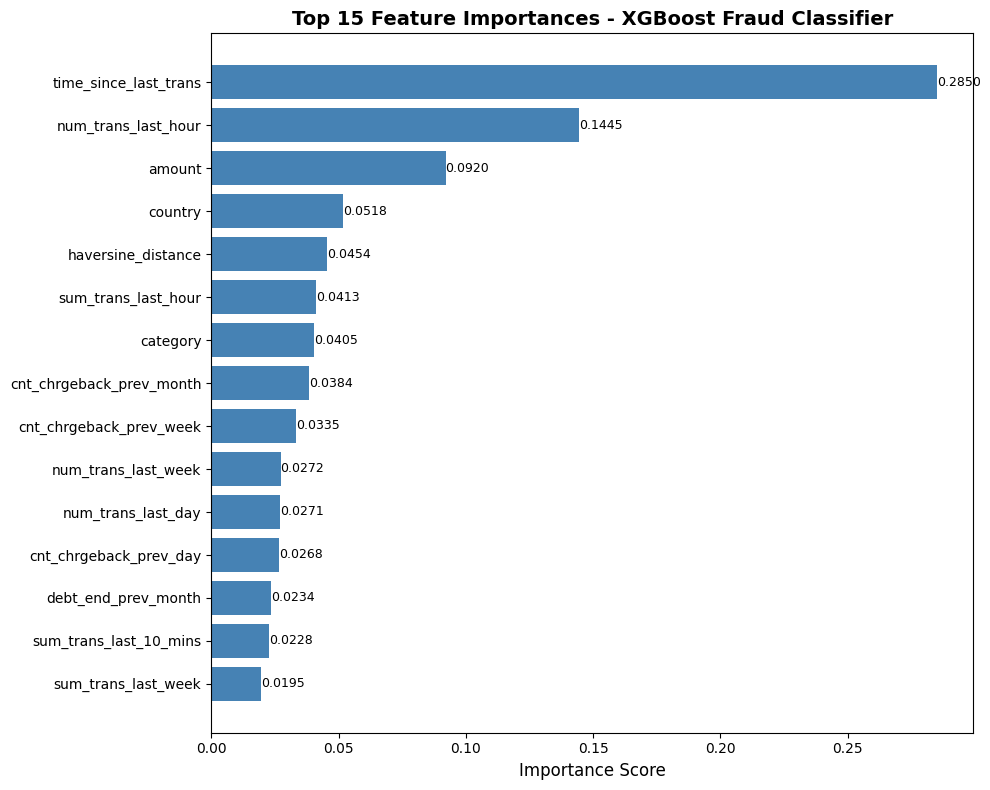


Interpretation:
Features with higher importance scores have more influence on fraud predictions.
Geographic indicators, transaction patterns, and merchant history are key fraud signals.


In [22]:
# Feature Importance
# Analyze which features are most important for fraud detection
import matplotlib.pyplot as plt

# Access model and preprocessor from the pipeline
xgb_model = full_pipeline.named_steps['model']
fitted_preprocessor = full_pipeline.named_steps['preprocessor']

# Get feature names after preprocessing transformation
feature_names = fitted_preprocessor.get_feature_names_out()

# Get feature importance from the model
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 15 features
print("=" * 80)
print("TOP 15 MOST IMPORTANT FEATURES")
print("=" * 80)
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
bars = ax.barh(top_features['feature'], top_features['importance'], color='steelblue')
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 15 Feature Importances - XGBoost Fraud Classifier', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
    ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
            va='center', ha='left', fontsize=9, color='black')

plt.tight_layout()
feature_imp_fig = fig  # Store for saving later
plt.show()

print("\nInterpretation:")
print("Features with higher importance scores have more influence on fraud predictions.")
print("Geographic indicators, transaction patterns, and merchant history are key fraud signals.")

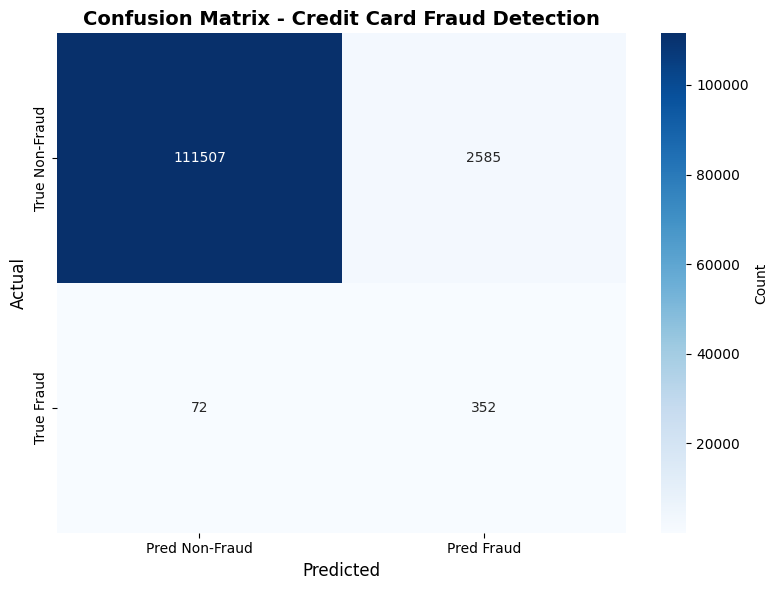

CONFUSION MATRIX BREAKDOWN
True Negatives:  111,507 (correctly identified non-fraud)
False Positives: 2,585 (non-fraud flagged as fraud)
False Negatives:    72 (fraud missed - CRITICAL)
True Positives:    352 (correctly identified fraud)

Key Insights:
  This represents 17.0% of all actual frauds.
  2585 legitimate transactions were flagged as fraud (false alarms).
  This is 2.27% of all legitimate transactions.


In [23]:
# Confusion Matrix
# Visualize model performance showing true/false positives and negatives

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predictions on the test set using the full pipeline (on RAW data)
# The pipeline handles preprocessing internally
y_pred = full_pipeline.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
df_cm = pd.DataFrame(cm, 
                     index=['True Non-Fraud', 'True Fraud'],
                     columns=['Pred Non-Fraud', 'Pred Fraud'])

sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix - Credit Card Fraud Detection', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
cm_fig = fig  # Store for saving later
plt.show()

# Print confusion matrix breakdown
print("=" * 80)
print("CONFUSION MATRIX BREAKDOWN")
print("=" * 80)
print(f"True Negatives:  {cm[0,0]:5,} (correctly identified non-fraud)")
print(f"False Positives: {cm[0,1]:5,} (non-fraud flagged as fraud)")
print(f"False Negatives: {cm[1,0]:5,} (fraud missed - CRITICAL)")
print(f"True Positives:  {cm[1,1]:5,} (correctly identified fraud)")

print("\nKey Insights:")
if cm[1,0] > 0:
    print(f"  WARNING: {cm[1,0]} fraudulent transactions were missed!")
    print(f"  This represents {cm[1,0]/(cm[1,0]+cm[1,1])*100:.1f}% of all actual frauds.")
if cm[0,1] > 0:
    print(f"  {cm[0,1]} legitimate transactions were flagged as fraud (false alarms).")
    print(f"  This is {cm[0,1]/(cm[0,0]+cm[0,1])*100:.2f}% of all legitimate transactions.")

In [24]:
# Classification Metrics
# Comprehensive evaluation with metrics appropriate for imbalanced classification

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve, auc,
    precision_score, recall_score, f1_score
)

# y_pred was already computed using full_pipeline.predict(X_test) in the confusion matrix cell

# Classification report
print("=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
report_dict = classification_report(y_test, y_pred, 
                                   target_names=['Non-Fraud', 'Fraud'],
                                   output_dict=True)
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Calculate key metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Precision-Recall AUC (more important than ROC-AUC for imbalanced data)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall_curve, precision_curve)

print("=" * 80)
print("KEY METRICS SUMMARY")
print("=" * 80)
print(f"PR-AUC Score:         {pr_auc:.4f}  <- More important for imbalanced data")
print(f"Precision (Fraud):    {precision:.4f}")
print(f"Recall (Fraud):       {recall:.4f}")
print(f"F1-Score (Fraud):     {f1:.4f}")

# Store metrics for model registry
metrics_dict = {
    'pr_auc': pr_auc,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'accuracy': report_dict['accuracy']
}

print("\nInterpretation:")
print(f"  - Precision: {precision*100:.1f}% of predicted frauds are actually fraudulent")
print(f"  - Recall: {recall*100:.1f}% of actual frauds were detected")
print(f"  - PR-AUC: {pr_auc:.4f} measures precision-recall tradeoff (higher is better)")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.98      0.99    114092
       Fraud       0.12      0.83      0.21       424

    accuracy                           0.98    114516
   macro avg       0.56      0.90      0.60    114516
weighted avg       1.00      0.98      0.99    114516



KEY METRICS SUMMARY
PR-AUC Score:         0.4753  <- More important for imbalanced data
Precision (Fraud):    0.1199
Recall (Fraud):       0.8302
F1-Score (Fraud):     0.2095

Interpretation:
  - Precision: 12.0% of predicted frauds are actually fraudulent
  - Recall: 83.0% of actual frauds were detected
  - PR-AUC: 0.4753 measures precision-recall tradeoff (higher is better)


In [25]:
# Create Model Directory
# Setup directory structure for saving model artifacts
import os

model_dir = "cc_fraud_model"
images_dir = model_dir + "/images"
os.makedirs(images_dir, exist_ok=True)

print("\nModel artifacts will be saved to:", model_dir)


Model artifacts will be saved to: cc_fraud_model


In [26]:
# Save Model Artifacts
# Save the unified Pipeline (preprocessor + model) as a single file

import joblib

print("=" * 80)
print("SAVING MODEL ARTIFACTS")
print("=" * 80)

# Save the unified pipeline (preprocessor + XGBoost in one file)
pipeline_path = model_dir + "/cc_fraud_pipeline.pkl"
joblib.dump(full_pipeline, pipeline_path)
print(f"Unified pipeline saved to: {pipeline_path}")

# Save confusion matrix image
cm_fig.savefig(images_dir + "/confusion_matrix.png", dpi=100, bbox_inches='tight')
print(f"Confusion matrix saved to: {images_dir}/confusion_matrix.png")

# Save feature importance image  
feature_imp_fig.savefig(images_dir + "/feature_importance.png", dpi=100, bbox_inches='tight')
print(f"Feature importance saved to: {images_dir}/feature_importance.png")

print("\n" + "=" * 80)
print("ALL ARTIFACTS SAVED SUCCESSFULLY")
print("=" * 80)
print(f"Total files: 3")
print(f"  - Pipeline: cc_fraud_pipeline.pkl (preprocessor + model combined)")
print(f"  - Visualizations: 2 PNG files")
print("\nFor inference: load cc_fraud_pipeline.pkl -> call pipeline.predict(raw_features)")

SAVING MODEL ARTIFACTS
Unified pipeline saved to: cc_fraud_model/cc_fraud_pipeline.pkl
Confusion matrix saved to: cc_fraud_model/images/confusion_matrix.png


Feature importance saved to: cc_fraud_model/images/feature_importance.png

ALL ARTIFACTS SAVED SUCCESSFULLY
Total files: 3
  - Pipeline: cc_fraud_pipeline.pkl (preprocessor + model combined)
  - Visualizations: 2 PNG files

For inference: load cc_fraud_pipeline.pkl -> call pipeline.predict(raw_features)


In [27]:
# Add the predictor script to the model's directory
predictor_script="ccfraud-predictor.py"
src = Path(f"notebooks/{predictor_script}")
dst_dir = Path(model_dir)
try:
    shutil.copy(src, dst_dir / src.name)
except:
    src = Path(predictor_script)
    shutil.copy(src, dst_dir / src.name)

In [28]:
# Register Model in Hopsworks
# Upload unified pipeline to Hopsworks Model Registry for versioning and deployment

print("=" * 80)
print("REGISTERING MODEL IN HOPSWORKS")
print("=" * 80)

# Format metrics for model registry (must be strings)
metrics_for_registry = {
    'pr_auc': f"{metrics_dict['pr_auc']:.4f}",
    'precision': f"{metrics_dict['precision']:.4f}",
    'recall': f"{metrics_dict['recall']:.4f}",
    'f1_score': f"{metrics_dict['f1_score']:.4f}",
    'accuracy': f"{metrics_dict['accuracy']:.4f}",
    'scale_pos_weight': f"{scale_pos_weight:.2f}",
    'n_train_samples': str(len(y_train)),
    'n_fraud_train': str(n_positive),
    'imbalance_ratio': f"{scale_pos_weight:.2f}"
}

print("Model metadata:")
for key, value in metrics_for_registry.items():
    print(f"  {key:20s}: {value}")

model_name = "cc_fraud_xgboost_model"
# Create model in registry
cc_fraud_model = mr.python.create_model(
    name=model_name,
    metrics=metrics_for_registry,
    feature_view=fv,
    description="Credit Card Fraud Detection - Unified sklearn Pipeline with XGBoost. "
                "Single artifact contains preprocessor (imputation + encoding) and classifier. "
                f"Trained on {len(y_train):,} samples with {n_positive} fraud cases. "
                f"Uses {len(X_train.columns)} raw features, preprocessed internally by pipeline."
)

# Upload model directory to registry
cc_fraud_model.save(model_dir)

print("\n" + "=" * 80)
print("MODEL REGISTRATION COMPLETE")
print("=" * 80)
print(f"Model name: {model_name}")
print(f"Version: {cc_fraud_model.version}")
print(f"Artifact: cc_fraud_pipeline.pkl (unified preprocessor + model)")

REGISTERING MODEL IN HOPSWORKS
Model metadata:
  pr_auc              : 0.4753
  precision           : 0.1199
  recall              : 0.8302
  f1_score            : 0.2095
  accuracy            : 0.9768
  scale_pos_weight    : 224.96
  n_train_samples     : 322452
  n_fraud_train       : 1427
  imbalance_ratio     : 224.96


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/cc_fraud_model/ccfraud-predictor.py: 0.000%|          | 0/…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/cc_fraud_model/cc_fraud_pipeline.pkl: 0.000%|          | 0…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/cc_fraud_model/preprocessor.pkl: 0.000%|          | 0/5352…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/cc_fraud_model/cc_fraud_xgboost.pkl: 0.000%|          | 0/…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/cc_fraud_model/images/confusion_matrix.png: 0.000%|       …

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/cc_fraud_model/images/feature_importance.png: 0.000%|     …

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/model_schema.json: 0.000%|          | 0/2100 elapsed<00:00…

Model created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/120/models/cc_fraud_xgboost_model/1

MODEL REGISTRATION COMPLETE
Model name: cc_fraud_xgboost_model
Version: 1
Artifact: cc_fraud_pipeline.pkl (unified preprocessor + model)


In [29]:
ms = proj.get_model_serving()
best_model = mr.get_best_model(name=model_name, metric="f1_score", direction="max")

# If the model I trained is better than the existing model deployment, replace it with this one
if best_model.version == cc_fraud_model.version:
    print(f"This is the best model version at: {best_model.version_path}")
    predictor_path = os.path.join(best_model.version_path, f"Files/{predictor_script}")
    deployment_name = "ccfraud"
    try:
        deployment = ms.get_deployment(deployment_name)
        deployment.delete(force=True)
        print(f"Deleted deployment {deployment_name}")
    except:
        print("Deployment not running")
    deployment = best_model.deploy(name=deployment_name, 
                                   script_file=predictor_path, 
                                   environment="pandas-inference-pipeline"
                                  )
    deployment.start(await_running=180)
    deployment_state = deployment.get_state().describe()
else:
    print("Not deploying this model, as its performance is worse than the existing deployment")

This is the best model version at: /Projects/jim/Models/cc_fraud_xgboost_model/1
Deployment not running


Deployment created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/120/deployments/2064


Before making predictions, start the deployment by using `.start()`


  0%|          | 0/5 [00:00<?, ?it/s]

Start making predictions by using `.predict()`


{
    "available_instances": 1,
    "condition": {
        "reason": "Deployment is ready",
        "status": true,
        "type": "READY"
    },
    "deployed": "2026-01-21T10:35:29.000Z",
    "hopsworks_inference_path": "/project/120/inference/serving/ccfraud",
    "model_server_inference_path": "/v1/models/ccfraud",
    "revision": "21429495",
    "status": "Running"
}
